## Energy Feature - Differential Entropy and Control functions 

In [3]:
from src.data.components.helsinki import HelsinkiProminenceExtractor
from src.data.components.datasets import TokenTaggingDataset
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
import numpy as np
import os
from tqdm import tqdm

from src.utils.text_processing import python_lowercase_remove_punctuation
from src.utils.text_processing import get_wordlist_from_string

# only to create a valid dataset
dummy_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", add_special_tokens=True)

### Load data

In [4]:
WAV_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTS"
LAB_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTSCorpusLabel"
PHONEME_LAB_ROOT = "/Users/lukas/Desktop/projects/MIT/data/LibriTTSCorpusLabelPhoneme"
DATA_CACHE = "/Users/lukas/Desktop/projects/MIT/data/cache"

TRAIN_FILE = "train-clean-360"
VAL_FILE = "dev-clean"
TEST_FILE = "test-clean"

SAVE_DIR = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/precomputed/predictions/emnlp/energy_mean"

In [5]:
from src.data.energy_regression_datamodule import (
    EnergyRegressionDataModule as DataModule,
)

In [6]:
dm = DataModule(
    wav_root=WAV_ROOT,
    lab_root=LAB_ROOT,
    phoneme_lab_root=PHONEME_LAB_ROOT,
    data_cache=DATA_CACHE,
    train_file=TRAIN_FILE,
    val_file=VAL_FILE,
    test_file=TEST_FILE,
    dataset_name="libritts",
    model_name="gpt2",
    energy_mode="mean",
    score_last_token=True,
)

In [7]:
dm.setup()

Using GPT2 tokenizer
Dataloader: padding with token id: 50256
Loading data from cache: ('/Users/lukas/Desktop/projects/MIT/data/cache/train-clean-360', 'energy_mean')


Preprocessing samples: 100%|██████████| 108321/108321 [00:59<00:00, 1820.38it/s]


Failed 6878/108321
Loading data from cache: ('/Users/lukas/Desktop/projects/MIT/data/cache/dev-clean', 'energy_mean')


Preprocessing samples: 100%|██████████| 4217/4217 [00:02<00:00, 1905.53it/s]


Failed 217/4217
Loading data from cache: ('/Users/lukas/Desktop/projects/MIT/data/cache/test-clean', 'energy_mean')


Preprocessing samples: 100%|██████████| 4389/4389 [00:02<00:00, 1883.29it/s]

Failed 270/4389
Train dataset size: 101443
Validation dataset size: 4000
Test dataset size: 4119


In [8]:
train_texts, train_labels = dm.train_texts, dm.train_durations
val_texts, val_labels = dm.val_texts, dm.val_durations
test_texts, test_labels = dm.test_texts, dm.test_durations

print(
    f"Lengths of train, val, test in samples: {len(train_texts), len(val_texts), len(test_texts)}"
)

Lengths of train, val, test in samples: (108321, 4217, 4389)


In [9]:
from src.utils.text_processing import assign_labels_to_sentences

all_train_words, all_train_labels = assign_labels_to_sentences(
    train_texts, train_labels
)
all_dev_words, all_dev_labels = assign_labels_to_sentences(val_texts, val_labels)
all_test_words, all_test_labels = assign_labels_to_sentences(test_texts, test_labels)

print(f"Words and labels train: {len(all_train_words), len(all_train_labels)}")
print(f"Words and labels dev: {len(all_dev_words), len(all_dev_labels)}")
print(f"Words and labels test: {len(all_test_words), len(all_test_labels)}")

Words and labels train: (1875477, 1875477)
Words and labels dev: (72537, 72537)
Words and labels test: (77979, 77979)


### Kernel density estimation and Differential Entropy Computation

In [10]:
# bootstrapping to get confidence intervals
from sklearn.utils import resample
from scipy.stats import gaussian_kde
from src.utils.approximation import cross_validate_gkde_bandwidth
from src.utils.approximation import monte_carlo_diff_entropy

n_iterations = 10
n_train_size = int(len(all_train_labels) * 0.5)
n_dev_size = int(len(all_dev_labels) * 0.2)
n_test_size = int(len(all_test_labels) * 0.1)
print(
    f"n_train_size: {n_train_size}, n_dev_size: {n_dev_size}, n_test_size: {n_test_size}"
)

diff_entropy_list = []

for i in range(n_iterations):
    train_sample = resample(all_train_labels, n_samples=n_train_size)
    dev_sample = resample(all_dev_labels, n_samples=n_dev_size)
    test_sample = resample(all_test_labels, n_samples=n_test_size)
    best_bw = 0.1
    # best_bw = cross_validate_gkde_bandwidth(train_sample, dev_sample)
    print(f"Best bandwidth: {best_bw}")
    density = gaussian_kde(all_train_labels, bw_method=best_bw)
    mc_entropy = monte_carlo_diff_entropy(density, test_sample, len(test_sample))
    diff_entropy_list.append(mc_entropy)
    print(
        f"Finished iteration {i+1} out of {n_iterations} with diff entropy: {mc_entropy}"
    )

diff_entropy_list = np.array(diff_entropy_list)
print(f"Mean: {np.mean(diff_entropy_list)}, std: {np.std(diff_entropy_list)}")

n_train_size: 937738, n_dev_size: 14507, n_test_size: 7797
Best bandwidth: 0.1
Finished iteration 1 out of 10 with diff entropy: 0.8071778972670585
Best bandwidth: 0.1
Finished iteration 2 out of 10 with diff entropy: 0.8183559493767644
Best bandwidth: 0.1
Finished iteration 3 out of 10 with diff entropy: 0.8100619016270001
Best bandwidth: 0.1
Finished iteration 4 out of 10 with diff entropy: 0.8092227915960647
Best bandwidth: 0.1
Finished iteration 5 out of 10 with diff entropy: 0.8201583065403801
Best bandwidth: 0.1
Finished iteration 6 out of 10 with diff entropy: 0.7986916056087134
Best bandwidth: 0.1
Finished iteration 7 out of 10 with diff entropy: 0.8226221497858995
Best bandwidth: 0.1
Finished iteration 8 out of 10 with diff entropy: 0.8154824087977184
Best bandwidth: 0.1
Finished iteration 9 out of 10 with diff entropy: 0.8211064248542582
Best bandwidth: 0.1
Finished iteration 10 out of 10 with diff entropy: 0.8234830497694948
Mean: 0.8146362485223353, std: 0.00767487971227235

In [11]:
from src.utils.approximation import cross_validate_gkde_bandwidth

best_bw = cross_validate_gkde_bandwidth(
    all_train_labels[:20000], all_test_labels[:5000]
)
print(f"best bw {best_bw}")

param scott, score -0.764683092262885
new best param scott, score -0.764683092262885
param silverman, score -0.76487154702333
param 0.01, score -0.770325437213088
param 0.1, score -0.7640451191509781
new best param 0.1, score -0.7640451191509781
param 0.3, score -0.7722957857039019
best bw 0.1


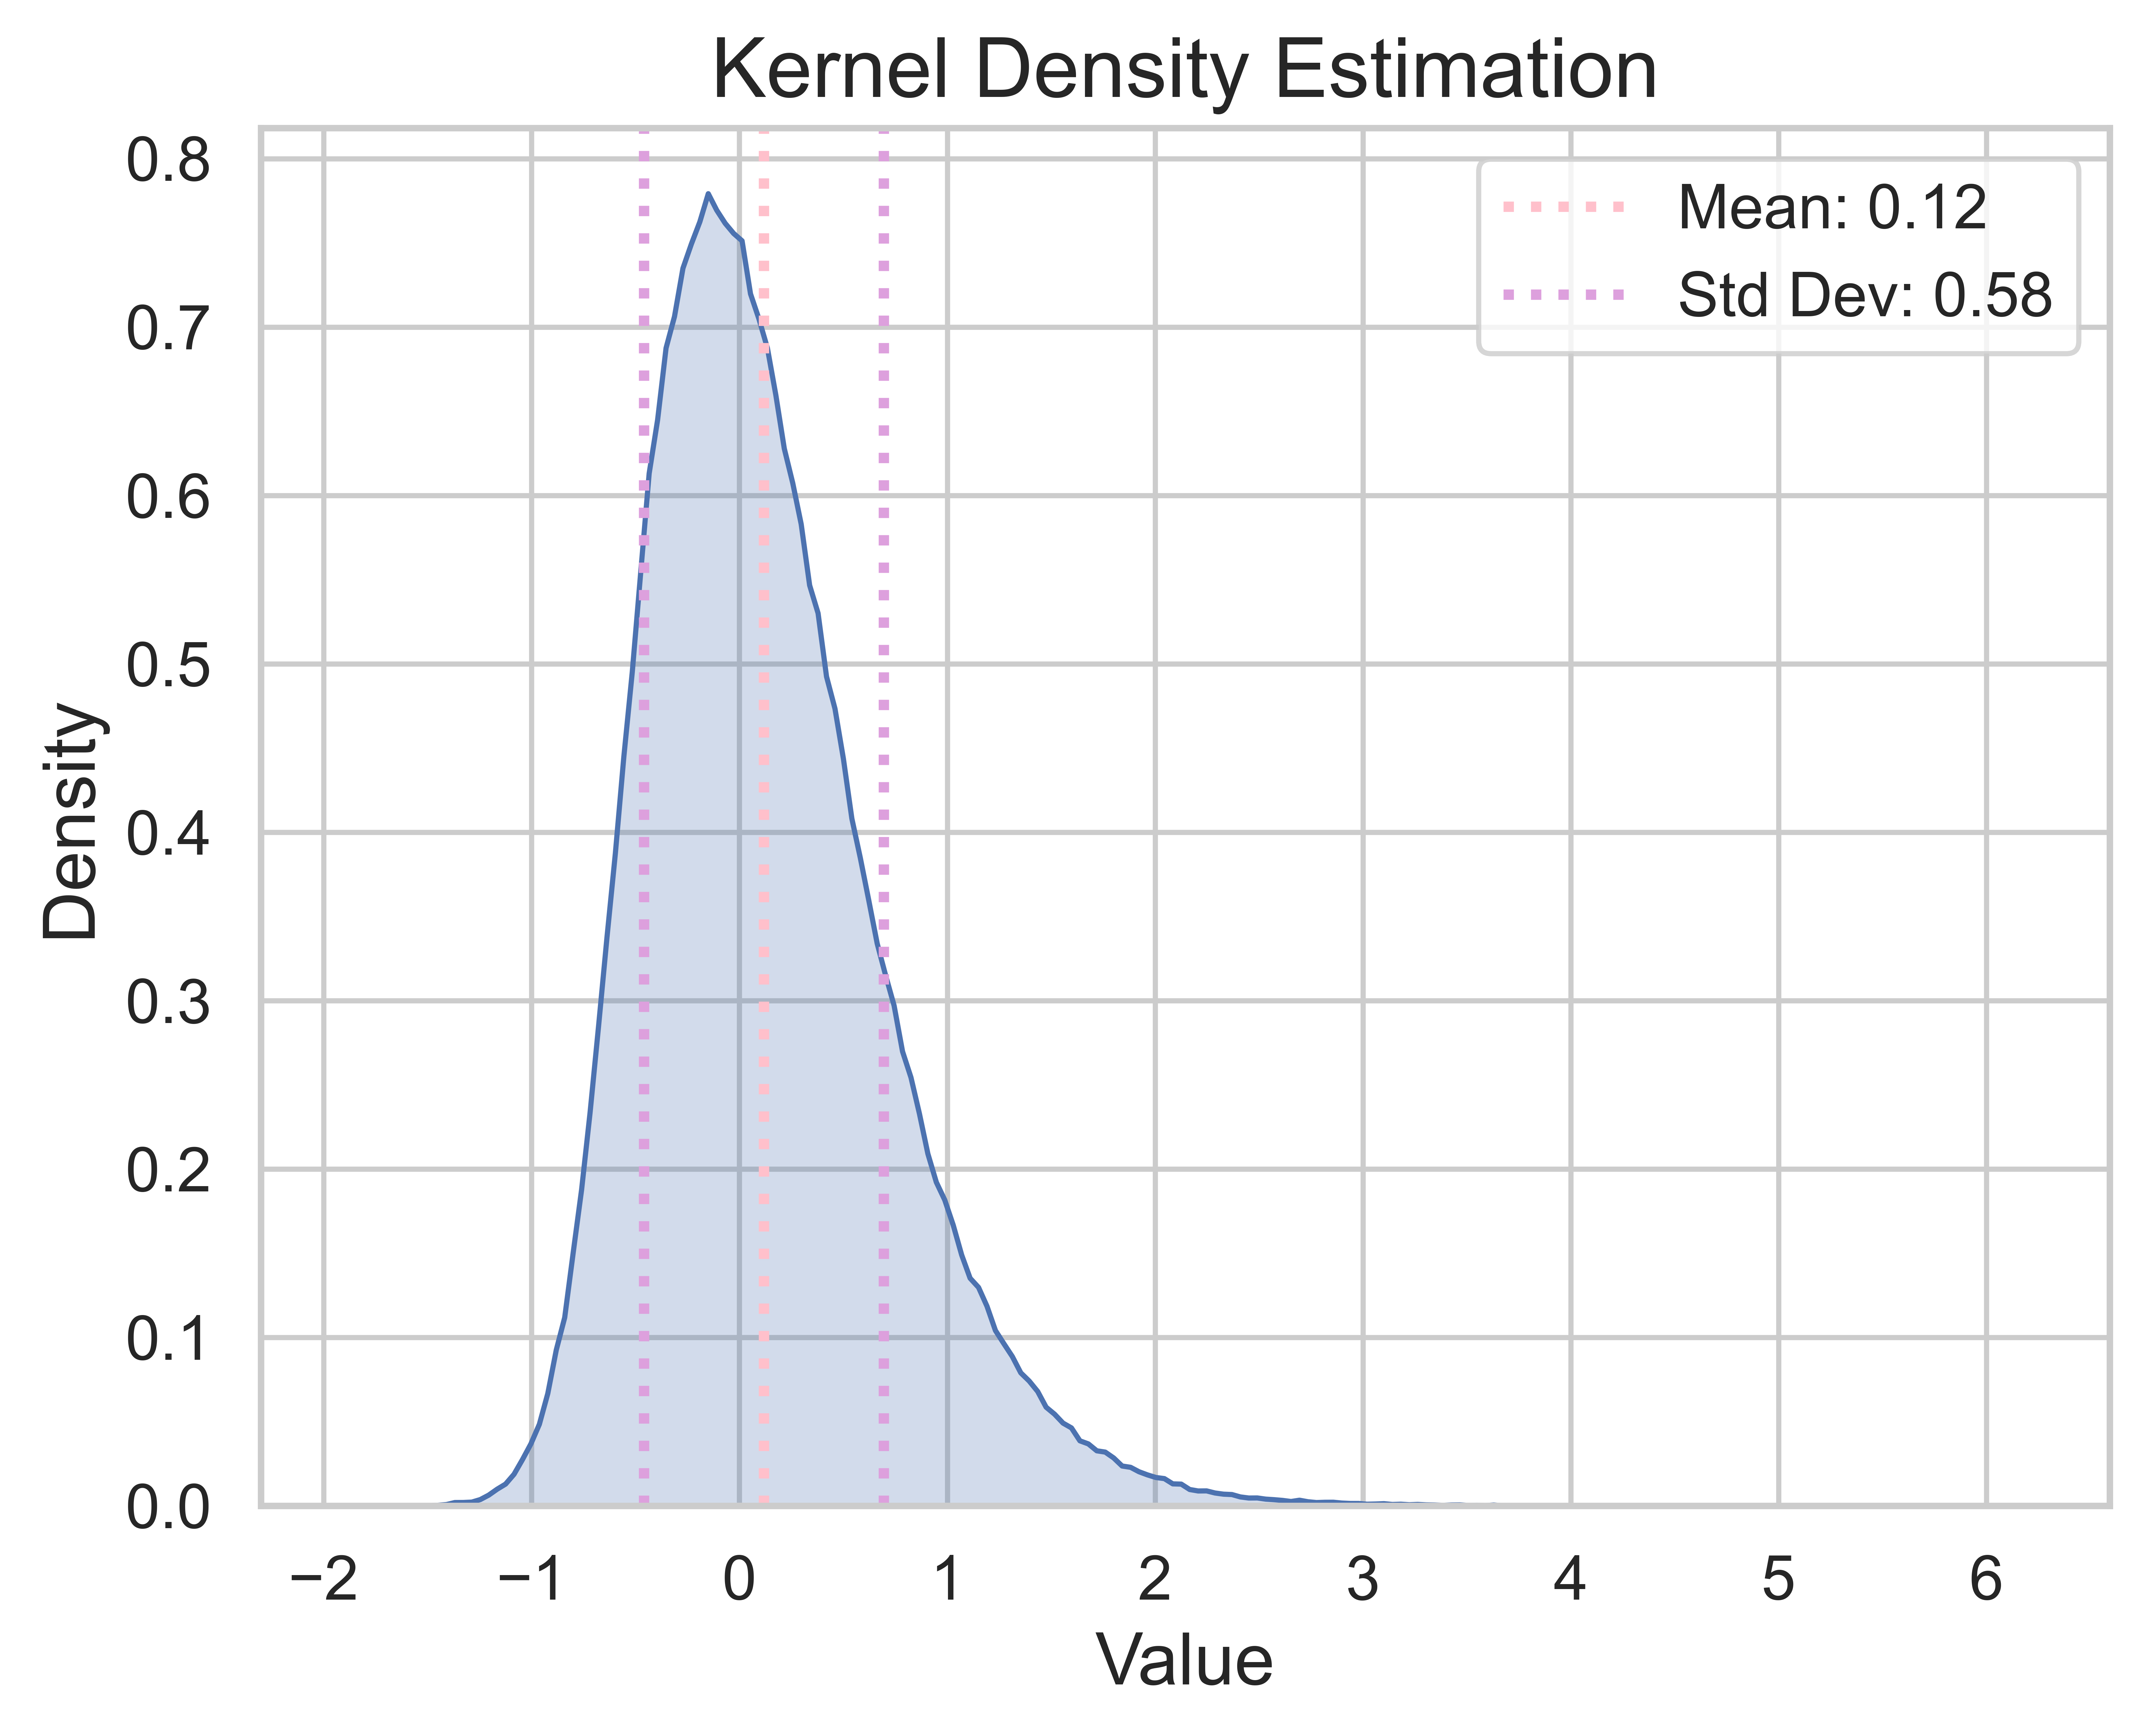

In [12]:
from src.utils.plots import plot_kde

plot_kde(all_train_labels, bw_adjust=0.1)

In [13]:
# kernel density estimation
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

density = gaussian_kde(all_train_labels, bw_method=0.1)

In [14]:
from src.utils.approximation import monte_carlo_diff_entropy

diff_entropy = monte_carlo_diff_entropy(density, all_test_labels, 1000)
print(f"Differential entropy: {diff_entropy:.4f}")

Differential entropy: 0.7906


## Store text and labels as pickle 

In [15]:
SAVE_PATH = "/Users/lukas/Desktop/projects/MIT/data/baseline_data/energy"

In [16]:
import pickle

with open(SAVE_PATH + "/train_words.pkl", "wb") as f:
    pickle.dump(all_train_words, f)

with open(SAVE_PATH + "/train_labels.pkl", "wb") as f:
    pickle.dump(all_train_labels, f)

with open(SAVE_PATH + "/test_words.pkl", "wb") as f:
    pickle.dump(all_test_words, f)

with open(SAVE_PATH + "/test_labels.pkl", "wb") as f:
    pickle.dump(all_test_labels, f)

with open(SAVE_PATH + "/dev_words.pkl", "wb") as f:
    pickle.dump(all_dev_words, f)

with open(SAVE_PATH + "/dev_labels.pkl", "wb") as f:
    pickle.dump(all_dev_labels, f)

# Baseline Models and Control Functions 

In [17]:
SAVE_PATH = "/Users/lukas/Desktop/projects/MIT/data/baseline_data/energy"

In [18]:
# load data again

import pickle

SAVE_PATH = "/Users/lukas/Desktop/projects/MIT/data/baseline_data/prominence_absolute"

with open(SAVE_PATH + "/train_words.pkl", "rb") as f:
    all_train_words = pickle.load(f)

with open(SAVE_PATH + "/train_labels.pkl", "rb") as f:
    all_train_labels = pickle.load(f)

with open(SAVE_PATH + "/test_words.pkl", "rb") as f:
    all_test_words = pickle.load(f)

with open(SAVE_PATH + "/test_labels.pkl", "rb") as f:
    all_test_labels = pickle.load(f)

with open(SAVE_PATH + "/dev_words.pkl", "rb") as f:
    all_dev_words = pickle.load(f)

with open(SAVE_PATH + "/dev_labels.pkl", "rb") as f:
    all_dev_labels = pickle.load(f)

print(len(all_train_words), len(all_train_labels))
print(len(all_dev_words), len(all_dev_labels))
print(len(all_test_words), len(all_test_labels))

1835868 1835868
91509 91509
80422 80422


In [19]:
from src.models.baselines.GloVe import GloVeModel

glove_model = GloVeModel(
    model_path="/Users/lukas/Desktop/projects/MIT/data/models/glove/glove.6B.100d.txt"
)

Loading GloVe: 100%|██████████| 400000/400000 [00:05<00:00, 67722.65it/s]


In [20]:
train_emb = [glove_model.get_word_embedding(word) for word in all_train_words]
dev_emb = [glove_model.get_word_embedding(word) for word in all_dev_words]
test_emb = [glove_model.get_word_embedding(word) for word in all_test_words]

print(
    f"Shapes of train, dev, test embeddings: {len(train_emb)}, {len(dev_emb)}, {len(test_emb)}"
)

Shapes of train, dev, test embeddings: 1835868, 91509, 80422


In [21]:
# create numpy arrays and print shapes
import numpy as np

train_emb = np.array(train_emb)
dev_emb = np.array(dev_emb)
test_emb = np.array(test_emb)

train_labels = np.array(all_train_labels)
dev_labels = np.array(all_dev_labels)
test_labels = np.array(all_test_labels)


print(
    f"Shapes of train, dev, test embeddings: {train_emb.shape}, {dev_emb.shape}, {test_emb.shape}"
)

print(
    f"Shapes of train, dev, test labels: {train_labels.shape}, {dev_labels.shape}, {test_labels.shape}"
)

Shapes of train, dev, test embeddings: (1835868, 100), (91509, 100), (80422, 100)
Shapes of train, dev, test labels: (1835868,), (91509,), (80422,)


# Sklearn LinReg

In [22]:
# train sklearn model
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(train_emb, all_train_labels)

# compute mse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

predictions = reg.predict(test_emb)
mse = mean_absolute_error(all_test_labels, predictions)
print(f"Mean absolute error: {mse}")

# compute r2
r2 = r2_score(all_test_labels, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(all_test_labels, predictions)
print(f"Pearson correlation: {pearson}")

Mean absolute error: 0.49167411669765554
R2 score: 0.2874557404172531
Pearson correlation: PearsonRResult(statistic=0.536189415400231, pvalue=0.0)
